In [21]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm  # for progree bar
import torch.optim as optim
import cv2 as cv
import matplotlib.pyplot as plt
import sys
#from model import UNET



## UNEt Arcitecture

In [22]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # nn.conv2d(in_channels, out_channels, KernalSize = 3, stride = 1, padding = 1)
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3 , 1, 1, bias=False ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x) 

In [23]:

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            
            # We are doing up and 2-Convs
            self.ups.append(DoubleConv(feature*2, feature)) 
        
        # The connected Bottom part    
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        
        # Final up conv
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []
        
        # Downward
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x) 
        
        # bottleneck
        x = self.bottleneck(x)
        
        # reverse list [::-1]
        skip_connections = skip_connections[::-1]
        
        # Upward
        for idx in range(0, len(self.ups), 2):
            # upSampling
            x = self.ups[idx](x)
            
            # getting skip connections 
            skip_connection = skip_connections[idx // 2]
            
            if x.shape != skip_connection.shape:
                print(f" Size not matches Add padding ")
                # Resizing
                x = TF.resize(x, size=skip_connection.shape[2:])
                
            # concatinating skip connections
            concat_skip = torch.cat((skip_connection , x), dim = 1)
            
            # Doubel conv
            x = self.ups[idx+1](concat_skip)
            
        return self.final_conv(x)
        

In [24]:
def test():
     x = torch.randn((3, 1, 160, 160))
     model = UNET(in_channels=1, out_channels=1)
     preds = model(x)
     print(preds.shape)
     print(x.shape)
     assert preds.shape == x.shape
     
if __name__ == "__main__":
    test()
        

torch.Size([3, 1, 160, 160])
torch.Size([3, 1, 160, 160])


## DataSet

In [25]:
class CancerDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.trasnform = transform
        self.images = os.listdir(image_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".tif",".png"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0  # because we use sigmoid in our last activation
        
        if self.trasnform is not None:
            augmentation = self.trasnform(image=image, mask=mask)
            image = augmentation["image"]
            mask = augmentation["mask"]
            
        return image, mask

## Training

### Hyperparameters

In [26]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
NUM_EPOCHS = 100
NUM_WORKERS = 2
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 240
PIN_MEMORY = True
LOAD_MODEL = True
TRAIN_IMG_DIR = "D:\Ovarian Cancer Cells\DataSet\Train\Images"
TRAIN_MASK_DIR = "D:\Ovarian Cancer Cells\DataSet\Train\Masks"
VAL_IMG_DIR = "D:\Ovarian Cancer Cells\DataSet\Validation\Images"
VAL_MASK_DIR = "D:\Ovarian Cancer Cells\DataSet\Validation\Masks"

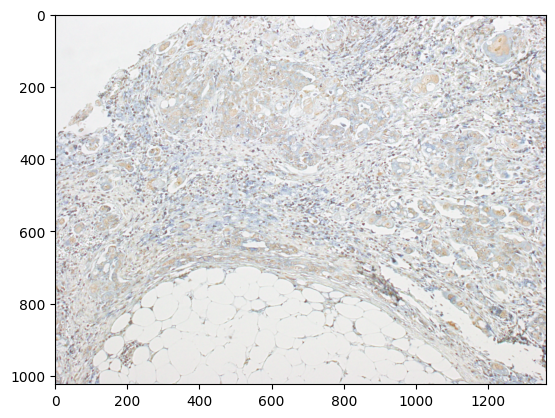

In [27]:
img = cv.imread(TRAIN_IMG_DIR+'/6-1-1 #2.tif')
plt.imshow(img)

In [28]:
import os
os.path.exists(TRAIN_IMG_DIR)

True

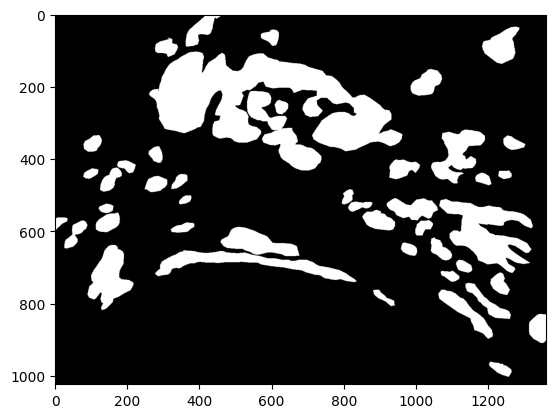

In [29]:
img = cv.imread(TRAIN_MASK_DIR+'/6-1-1 #2.png')
plt.imshow(img)

In [ ]:
TRAIN_IMG_DIR = "D:\Ovarian Cancer Cells\DataSet\Train\Images"
TRAIN_MASK_DIR = "D:\Ovarian Cancer Cells\DataSet\Train\Masks"
VAL_IMG_DIR = "D:\Ovarian Cancer Cells\DataSet\Validation\Images"
VAL_MASK_DIR = "D:\Ovarian Cancer Cells\DataSet\Validation\Masks"